# 🧠 Preprocessing and Analysis Pipeline for Structural Connectivity Matrices (FA) – HCB Cohort

This notebook implements a complete pipeline for the preprocessing and analysis of **structural connectivity matrices (FA)** from the HCB cohort. Each subject is associated with clinical information that allows stratification and statistical analysis.

---

## 🔧 Pipeline Overview

### 1. **Loading clinical and connectivity data**
- Structural FA matrices (76×76) are loaded for 178 subjects.
- Clinical metadata are loaded from a `.pkl` file (`clinic_df`), containing variables such as:
  - `age`, `sex`
  - `controls_ms` (0 = control, 1 = patient)
  - `dd` (disease duration), `edss`, `mstype`
- Using a file of ROI labels (`mindboggle_ROIs.txt`), each connection is annotated with its **source and target region names**.
- Metadata includes pair indices, region names, and optional hemispheric information.

---

### 2. **Matrix vectorization**
- Only the upper triangle of each matrix is retained (due to symmetry), reducing dimensionality and avoiding redundancy.
- The result is a DataFrame of size (subjects × connections), with 2850 connections per subject.

---

### 3. **Detection of structurally absent connections**
- A diagnostic step detects connections that are **zero across all subjects**.
- These connections are visualized and **excluded from imputation and correction steps**, but are **restored after processing**.

---

### 4. **Imputation of zero values**
Two strategies are applied:

- **Median imputation**: Each zero is replaced with the **median** of the corresponding connection (excluding zeros).
- **K-Nearest Neighbors (KNN)**: Each zero is imputed using the values of the 5 most similar subjects.
- Structurally absent connections (all-zero columns) are **preserved** as zeros.

---

### 5. **Covariate correction**
- Linear regression is applied **per connection** to remove effects of `age` and `sex`.
- The **residuals** of these models are used as corrected values.
- All-zero columns are skipped during fitting and restored afterward.

---

### 6. **Z-score normalization**
- After covariate correction, values are standardized (mean = 0, std = 1) per connection using Z-score scaling.
- Preserves the same shape; all-zero columns remain unaffected.

---

### 7. **Batch harmonization with ComBat**
- The `SITE` variable (based on `redcap_event_name`) is used to define **batch acquisition**.
- `neuroHarmonize` (ComBat) is applied to remove inter-site variability.
- Batches with fewer than 3 subjects are excluded.
- All-zero columns are removed before harmonization and added back afterward.

---

### 8. **Masking of weak connections**
- Connections with values below `0.1` in **more than 60% of control subjects** are considered weak.
- These are **masked (set to zero)** rather than removed.
- Preserves comparability between subjects while suppressing noise.

---

### 9. **Visualization of Connectivity Matrices Before and After Corrections**

Group-wise mean connectivity matrices are computed and visualized for both controls and patients.  
Comparisons are shown at multiple stages of the pipeline:

- Before preprocessing (original raw matrices)
- After imputation, covariate correction, ComBat harmonization and mask weak connection (Median & KNN strategies)

These visualizations help assess how preprocessing steps affect overall brain connectivity patterns and highlight structural differences between groups.

---
### 10. **Demographic and clinical stratification**
- The pipeline enables stratified analyses based on:
  - **MS type** (`mstype`: RRMS, SPMS, PPMS)
  - **EDSS severity** (grouped into clinical ranges)
  - **Disease duration** (`dd`), binned into fine-grained categories
- Boxplots, matrices, and summary statistics are provided for each group.
 
---

### 11. **Export of results**
- Corrected matrices are saved as individual `.csv` files.
- Subject IDs are exported per subgroup (e.g., by `dd`, `edss_group`).
- Group summary statistics (age, EDSS, duration) are exported for reporting.

---

## 📦 Ready for reuse:
This pipeline is ready to be replicated for:
- **Other connectivity layers**
- **Other cohorts**

Minimal changes are needed—just adjust the input matrix files and clinical metadata accordingly.


In [ ]:
# ===========================
#    Preprocessing Pipeline
# ===========================
# For structural connectivity matrices (FA)
# Includes:
# - Loading clinical data and connectivity matrices
# - Detection of structurally absent connections
# - Imputation of zero values (Median, KNN)
# - Covariate correction (age, sex)
# - Reconstruction and saving of corrected matrices
# - Visualization of group mean matrices (before and after correction)

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import os
import glob
from neuroHarmonize import harmonizationLearn
from scipy.stats import ttest_ind, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt


# === 1.A Load clinical data ===
def load_dataframe(filepath):
    """
    Load clinical data from file, detecting format.

    Args:
        filepath (str or Path): Path to the clinical data file.

    Returns:
        DataFrame: Loaded clinical data.
    """
    if str(filepath).endswith('.pkl'):
        df = pd.read_pickle(filepath)
    elif str(filepath).endswith('.csv'):
        df = pd.read_csv(filepath)
    elif str(filepath).endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif str(filepath).endswith('.feather'):
        df = pd.read_feather(filepath)
    else:
        raise ValueError("❌ Unsupported file format.")
    
    print(f"✅ Clinical data loaded successfully from {filepath.name}") 
    return df

ruta_hcb = Path('F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB') 
clinic_df = load_dataframe(ruta_hcb / 'CLINIC_HCB.pkl')
clinic_df.set_index('id', inplace=True)
clinic_df.head()

In [ ]:
# === 1B. Load FA matrices ===
def load_matrices_from_folder(folder_path):
    """
    Load all FA connectivity matrices from a folder.
    
    Args:
        folder_path (str): Path to the folder containing the matrices.

    Returns:
        dict: {subject_id: connectivity matrix}
    """
    matrices = {}
    file_list = glob.glob(os.path.join(folder_path, "*.csv"))
    # Extract subject IDs from filenames ("123456_FA_factor.csv" → "123456")
    for file in file_list:
        subj_id = os.path.basename(file).replace('_FA_factor.csv', '')
        # Convert DataFrame to array NumPy
        matrix = pd.read_csv(file, header=None).values
        # Save matrix in the dictionary (by id)
        matrices[subj_id] = matrix
        
    print(f"✅ Loaded {len(matrices)} FA matrices from '{folder_path}'")    
    return matrices
    # "123456": array([[...], [...], ...]),

folder_path = "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/FA_networks"
fa_matrices = load_matrices_from_folder(folder_path)
fa_matrices.keys() # Check the keys of the dictionary (subject IDs)

In [ ]:
# === 1C. Etiquets load from ROI ===
region_labels = {}
with open("F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/mindboggle_ROIs.txt") as f:
    for line in f:
        if line.strip().startswith('[') or not line.strip():
            continue
        idx, name = line.strip().split(maxsplit=1)
        region_labels[int(idx) - 1] = name
region_labels

In [ ]:
# === 2. Vectorization ===
def vectorize_matrices(matrices, region_labels):
    """
    Vectorize the upper triangle (k=1) of each connectivity matrix.
    
    Args:
        matrices (dict): {subject_id: connectivity matrix}
        region_labels (dict): Optional. Mapping from region index to name.

    Returns:
        df_vectors (DataFrame): Vectorized matrices (subjects x connections)
        triu_idx (tuple): Indices of upper triangle used.
        connection_metadata (DataFrame): Info per connection (i, j, Region_i, Region_j)
 
    """
    vectors = {}
    for subj, matrix in matrices.items():
        # Return coordenates (indexes) from the upper triangular (not including the diagonal)
        # [[0, a, b],
        #  [a, 0, c],
        #  [b, c, 0]] -> Returns [a, b, c]
        triu_idx = np.triu_indices_from(matrix, k=1)
        vectors[subj] = matrix[triu_idx]
    
    df_vectors = pd.DataFrame.from_dict(vectors, orient='index')
    
    # Get matrix size from the first element
    example_shape = next(iter(matrices.values())).shape

    print(f"✅ Vectorization complete: {df_vectors.shape[0]} subjects, {df_vectors.shape[1]} connections per subject (original matrix size: {example_shape[0]}x{example_shape[1]})")
    
    # === Build connection metadata (if labels provided) ===
    if region_labels is not None:
        data = []
        for col in range(len(triu_idx[0])):
            i = triu_idx[0][col]
            j = triu_idx[1][col]
            name_i = region_labels.get(i, f"Region{i}")
            name_j = region_labels.get(j, f"Region{j}")
            data.append((col, i, j, name_i, name_j))
        connection_metadata = pd.DataFrame(data, columns=["Col_Index", "i", "j", "Region_i", "Region_j"])
    else:
        connection_metadata = None

    return df_vectors, triu_idx, connection_metadata
    #return df_vectors, triu_idx

fa_vectors, triu_idx, connection_metadata = vectorize_matrices(fa_matrices,region_labels=region_labels)
print(fa_vectors.head()) # Check the first rows of the DataFrame
print(triu_idx) # Check the indexes of the upper triangular matrixc
connection_metadata # Check the connection metadata (if labels provided)

In [ ]:
# === 3. Function to visualize connections with all zeros (raw data) ===
def plot_zero_connections(df_vectors, triu_idx):
    """
    Detect and visualize connections (i, j) that are zero across all subjects.
    Also prints a table with these connections.

    Args:
        df_vectors (DataFrame): Vectorized connectivity matrices.
        triu_idx (tuple): Indices of upper triangle used in vectorization.

    Returns:
        zero_conn_indices (list): List of (i, j) pairs with all zeros.
    """
    # Detect connections (columns) where all subjects have zero
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    print(f"⚠️ Number of connections always zero: {len(zero_cols)}")

    # Map back to (i, j) pairs
    zero_conn_indices = [(triu_idx[0][col], triu_idx[1][col]) for col in zero_cols]

    # === Mask for visualization for all zero ===
    n = len(triu_idx[0]) + 1
    mask = np.zeros((n, n))
    for i, j in zero_conn_indices:
        mask[i, j] = 1
        mask[j, i] = 1  # Symmetric
    
    plt.figure(figsize=(8, 8))  # Size of the figure
    plt.imshow(mask, cmap="Reds")
    plt.title(f"Connections with all zeros ({len(zero_conn_indices)} connections)")
    plt.xlabel("Region")
    plt.ylabel("Region")  
    plt.colorbar(label="All-zero connection")
    plt.show() 
    
    # === Zoomed-in view of the mask (0-80) ===
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap="Reds")
    plt.xlim(0, 80)  # Columnas 0 to 80
    plt.ylim(80, 0)  # Invert axis to see symetric
    plt.title("Zoom connections regions 0-80 with all zeros")    
    #plt.xticks(range(0, 81, 10), range(0, 81, 10))
    plt.xlabel("Region")
    plt.ylabel("Region")
    plt.colorbar(label="All-zero connection")
    plt.show()

    # === Summary able ===
    if zero_conn_indices:
        df_zero = pd.DataFrame(zero_conn_indices, columns=['Region_i', 'Region_j'])
        print("\n🔍 Number of connections always zero:")
        print(df_zero)
    else:
        print("✅ No connections were found with all-zero values across subjects")

    print("✅ Detection and visualization of all-zero connections completed.\n")
    return zero_conn_indices

# Visualize connections "always zero" BEFORE pre-processing 
zero_conns = plot_zero_connections(fa_vectors, triu_idx)


In [ ]:
# === 4A. Imputation by median preserving zero columns ===
def impute_median_preserve_zeros(df_vectors):
    """
    Impute zeros by the median value of each connection (column),
    preserving columns that are originally all zeros.

    Args:
        df_vectors (DataFrame): Vectorized connectivity matrices.

    Returns:
        DataFrame: Imputed matrices.
        list: Columns originally all zeros.
    """
    # Detect columns that are all zeros
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    num_zero_cols = len(zero_cols)
    print(f"⚠️ Columns with all zeros detected and preserved: {num_zero_cols}")

    # Remove those columns temporarily
    df_tmp = df_vectors.drop(columns=zero_cols)

    # Impute zeros by median for each column
    df_imputed = df_tmp.copy()
    for col in df_tmp.columns:
        non_zero = df_tmp[col][df_tmp[col] != 0]
        median = non_zero.median() if not non_zero.empty else 0
        df_imputed[col] = df_tmp[col].replace(0, median)

    # Add back the all-zero columns
    for col in zero_cols:
        df_imputed[col] = 0.0

    # Restore original column order
    df_imputed = df_imputed[df_vectors.columns]

    print(f"✅ Median imputation completed: {df_imputed.shape[1] - num_zero_cols} columns imputed, {num_zero_cols} all-zero columns preserved (total: {df_imputed.shape[1]} connections).")
  
    return df_imputed, zero_cols

# Apply median imputation preserving zeros
fa_vectors_median, zero_cols_median = impute_median_preserve_zeros(fa_vectors)
fa_vectors_median.head() # Check the first rows of the DataFrame


In [ ]:
# === 4B. Imputation by KNN preserving zero columns ===
def impute_knn_preserve_zeros(df_vectors, n_neighbors=5):
    """
    Impute zeros using KNN, preserving columns that were originally all zeros.
    
    Args:
        df_vectors (DataFrame): Vectorized matrices.
        n_neighbors (int): Number of neighbors for KNN.

    Returns:
        DataFrame: Imputed matrices.
        list: Columns originally all zeros.
    """
     # Identify columns where all values are zero across subjects
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    num_zero_cols = len(zero_cols)
    print(f"⚠️ Columns with all zeros detected and preserved: {num_zero_cols}")
    
    # Temporarily remove all-zero columns from the dataset
    df_tmp = df_vectors.drop(columns=zero_cols)

    # Replace zeros with NaN for KNN imputation
    df_tmp = df_tmp.replace(0, np.nan)

    # Apply KNN imputation on remaining columns
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_array = imputer.fit_transform(df_tmp)

    # Convert the result back to a DataFrame
    df_imputed = pd.DataFrame(imputed_array, index=df_tmp.index, columns=df_tmp.columns)

    # Add back the previously removed all-zero columns, preserving them as 0.0
    for col in zero_cols:
        df_imputed[col] = 0.0

    # Restore original column order
    df_imputed = df_imputed[df_vectors.columns]

    print(f"✅ KNN imputation completed using {n_neighbors} neighbors: {df_imputed.shape[1] - num_zero_cols} columns imputed, {num_zero_cols} all-zero columns preserved (total: {df_imputed.shape[1]} connections).")
    
    return df_imputed, zero_cols

# Apply knn imputation preserving zeros
fa_vectors_knn, zero_cols = impute_knn_preserve_zeros(fa_vectors, n_neighbors=5)
fa_vectors_knn.head() # Check the first rows of the DataFrame


In [ ]:
 zero_cols = fa_vectors_median.columns[(fa_vectors_median == 0).all()]
 num_zero = len(zero_cols)
 print(f"⚠️ {num_zero} all-zero columns.")
 zero_cols = fa_vectors_knn.columns[(fa_vectors_knn == 0).all()]
 num_zero = len(zero_cols)
 print(f"⚠️ {num_zero} all-zero columns.")

In [ ]:
# === 5. Covariate correction ===

def correct_vectors_covariates(df_vectors, clinic_df, covariates=['age', 'sex'], verbose=True):
    """
    Correct each connection by covariates (e.g., age and sex) using linear regression.
    Preserves columns that are all zeros.

    Args:
        df_vectors (DataFrame): Vectorized connectivity matrices (subjects x connections).
        clinic_df (DataFrame): Clinical data.
        covariates (list): List of covariate names.
        verbose (bool): Whether to print info messages.

    Returns:
        DataFrame: Covariate-corrected matrix (same shape as input).
    """
    # Subjects in common between clinical and connectivity data
    common_subjects = df_vectors.index.intersection(clinic_df.index)

    # Select covariates and drop rows with missing values
    df_covars = clinic_df.loc[common_subjects, covariates].dropna()

    # Align matrix to subjects with valid covariates
    df_vectors = df_vectors.loc[df_covars.index]

    if verbose:
        print(f"🔍 Subjects with corrected data: {len(df_vectors)}")
        print(f"🔍 Covariates shape: {df_covars.shape}")
        print(f"🔍 Common subject IDs: {list(df_covars.index)}")

    # Detect all-zero columns (to skip them)
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    if verbose:
        print(f"⚠️ Skipping covariate correction for {len(zero_cols)} all-zero columns.")

    # Work only on valid columns
    df_tmp = df_vectors.drop(columns=zero_cols)

    # === Check for NaNs before regression ===
    nan_check_cols = df_tmp.columns[df_tmp.isna().any()]
    if len(nan_check_cols) > 0:
        print(f"⚠️ Detected {len(nan_check_cols)} columns with NaN values BEFORE regression.")
        print("🔍 Columns with NaNs:", list(nan_check_cols[:10]), "..." if len(nan_check_cols) > 10 else "")    
    
    # Initialize corrected matrix with NaN values
    corrected = pd.DataFrame(index=df_vectors.index, columns=df_vectors.columns)

    # Apply linear regression per connection
    for col in df_tmp.columns:
        y = df_tmp[col].values
        X = df_covars.values
        model = LinearRegression().fit(X, y)
        residuals = y - model.predict(X)
        corrected[col] = residuals

    # Reinsert all-zero columns as 0.0
    for col in zero_cols:
        corrected[col] = 0.0

    # Ensure original column order
    corrected = corrected[df_vectors.columns]

    # === Check for columns that remain NaN ===
    nan_cols_final = corrected.columns[corrected.isna().all()]
    if len(nan_cols_final) > 0:
        print(f"⚠️ Warning: {len(nan_cols_final)} columns remain completely NaN after correction.")
        print("📌 Columns:", list(nan_cols_final[:10]), "..." if len(nan_cols_final) > 10 else "")

    print(f"✅ Covariate correction completed on {corrected.shape[1] - len(zero_cols)} columns. Preserved {len(zero_cols)} all-zero columns.")

    return corrected

# Apply covariate correlation preserving zeros
fa_vectors_median_corrected = correct_vectors_covariates(fa_vectors_median, clinic_df)
fa_vectors_knn_corrected = correct_vectors_covariates(fa_vectors_knn, clinic_df)

print(fa_vectors_median_corrected.head()) # Check the first rows of the DataFrame
fa_vectors_knn_corrected.head() # Check the first rows of the DataFrame

In [ ]:
zero_cols = fa_vectors_median_corrected.columns[(fa_vectors_median_corrected == 0).all()]
num_zero = len(zero_cols)
print(f"⚠️ {num_zero} all-zero columns.")
zero_cols = fa_vectors_knn_corrected.columns[(fa_vectors_knn_corrected == 0).all()]
num_zero = len(zero_cols)
print(f"⚠️ {num_zero} all-zero columns.")

print(fa_vectors_knn_corrected.shape) 

In [ ]:
# === 6. Z-score Normalization ===
def normalize_vectors(df_vectors):
    """
    Apply Z-score normalization to vectorized connectivity matrices (subject x connection)
        
    Args:
        df_vectors (DataFrame): Vectorized connectivity matrices.

    Returns:
        DataFrame: Z-score normalized data.
    """
    # Detect and remove all-zero columns
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    num_zero = len(zero_cols)
    print(f"⚠️ Skipping normalization for {num_zero} all-zero columns.")

    df_tmp = df_vectors.drop(columns=zero_cols)

    # Z-score normalization on remaining data
    
    #scaler = StandardScaler()
    #df_normalized = pd.DataFrame(
    #    scaler.fit_transform(df_tmp),
    #    index=df_tmp.index,
    #    columns=df_tmp.columns
    #)
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(
        scaler.fit_transform(df_tmp),
        index=df_tmp.index,
        columns=df_tmp.columns
    )

    

    # Add back the zero columns
    for col in zero_cols:
        df_normalized[col] = 0.0

    # Restore original column order
    df_normalized = df_normalized[df_vectors.columns]

    print(f"✅ Z-score normalization completed on {df_normalized.shape[1] - num_zero} columns. Preserved {num_zero} all-zero columns.")
    return df_normalized

# Apply normalization to corrected data
fa_vectors_median_corrected_norm = normalize_vectors(fa_vectors_median_corrected)
fa_vectors_knn_corrected_norm = normalize_vectors(fa_vectors_knn_corrected)
print(fa_vectors_median_corrected_norm.head()) # Check the first rows of the DataFrame
fa_vectors_knn_corrected_norm.head() # Check the first rows of the DataFrame    

In [ ]:
zero_cols = fa_vectors_median_corrected_norm.columns[(fa_vectors_median_corrected_norm == 0).all()]
num_zero = len(zero_cols)
print(f"⚠️ {num_zero} all-zero columns.")
zero_cols = fa_vectors_knn_corrected_norm.columns[(fa_vectors_knn_corrected_norm == 0).all()]
num_zero = len(zero_cols)
print(f"⚠️ {num_zero} all-zero columns.")

print(fa_vectors_knn_corrected_norm.shape) 

In [ ]:
# === 7. Harmonization using ComBat (including controls, safe version) ===

# Create 'SITE' column for batch
clinic_df['SITE'] = clinic_df['redcap_event_name']
clinic_df.loc[clinic_df['controls_ms'] == 0, 'SITE'] = 'control_batch'

print("✅ Batch distribution (after assigning to controls):")
print(clinic_df['SITE'].value_counts())

# Align subjects between clinical data and FA matrix
common_ids = fa_vectors_median_corrected_norm.index.intersection(clinic_df.index)

# Prepare covariates and drop subjects with missing values
#covars = clinic_df.loc[common_ids, ['SITE', 'age', 'sex', 'controls_ms']].dropna()
covars = clinic_df.loc[common_ids, ['SITE', 'age', 'sex', 'controls_ms']]

# 🧹 Remove SITE batches with <3 subjects (to prevent NaNs)
site_counts = covars['SITE'].value_counts()
valid_sites = site_counts[site_counts >= 3].index
invalid_sites = site_counts[site_counts < 3].index
print(f"⚠️ Excluding {len(invalid_sites)} SITE(s) with <3 subjects: {invalid_sites.tolist()}")

covars_filtered = covars[covars['SITE'].isin(valid_sites)]
print(f"👥 Subjects before ComBat: {len(covars)} → after filtering: {len(covars_filtered)} (removed: {len(covars) - len(covars_filtered)})")

# Align FA matrices to filtered covariates
X_median = fa_vectors_median_corrected_norm.loc[covars_filtered.index]
X_knn = fa_vectors_knn_corrected_norm.loc[covars_filtered.index]

# === Detect and remove all-zero columns ===
zero_cols_median = X_median.columns[(X_median == 0).all()]
zero_cols_knn = X_knn.columns[(X_knn == 0).all()]
print(f"⚠️ Median version: {len(zero_cols_median)} all-zero columns excluded from ComBat")
print(f"⚠️ KNN version: {len(zero_cols_knn)} all-zero columns excluded from ComBat")

X_median_clean = X_median.drop(columns=zero_cols_median)
X_knn_clean = X_knn.drop(columns=zero_cols_knn)

# === Apply ComBat ===
model_median, data_combat_median = harmonizationLearn(X_median_clean.values, covars_filtered)
fa_vectors_median_combat = pd.DataFrame(data_combat_median,
                                        index=covars_filtered.index,
                                        columns=X_median_clean.columns)

model_knn, data_combat_knn = harmonizationLearn(X_knn_clean.values, covars_filtered)
fa_vectors_knn_combat = pd.DataFrame(data_combat_knn,
                                     index=covars_filtered.index,
                                     columns=X_knn_clean.columns)

# === Add back all-zero columns ===
for col in zero_cols_median:
    fa_vectors_median_combat[col] = 0.0
for col in zero_cols_knn:
    fa_vectors_knn_combat[col] = 0.0

# Restore original column order
fa_vectors_median_combat = fa_vectors_median_combat[X_median.columns]
fa_vectors_knn_combat = fa_vectors_knn_combat[X_knn.columns]

print("✅ ComBat harmonization completed for both Median and KNN imputations (controls included).")

print(fa_vectors_median_combat.head()) # Check the first rows of the DataFrame
print(fa_vectors_knn_combat.shape) 
fa_vectors_knn_combat.head() # Check the first rows of the DataFrame    

In [ ]:
zero_cols = fa_vectors_median_combat.columns[(fa_vectors_median_combat == 0).all()]
num_zero = len(zero_cols)
print(f"⚠️ {num_zero} all-zero columns.")
zero_cols = fa_vectors_knn_combat.columns[(fa_vectors_knn_combat == 0).all()]
num_zero = len(zero_cols)
print(f"⚠️ {num_zero} all-zero columns.")

print(fa_vectors_median_combat.shape) 

In [ ]:
# === 8. Mask weak connections (with zero-column detection) ===

def mask_weak_connections(vectors_df, clinic_df, threshold=0.1, max_ratio=0.6):
    """
    Mask connections where > max_ratio of controls have values below a threshold.
    Replaces those columns with zeros (instead of removing them).
    Also detects columns that are completely zero after masking.

    Args:
        vectors_df (DataFrame): Matrix of vectorized connectomes (subjects x connections).
        clinic_df (DataFrame): DataFrame with 'controls_ms' column.
        threshold (float): Weak connection threshold.
        max_ratio (float): Max proportion of controls allowed below threshold.

    Returns:
        vectors_masked (DataFrame): Same shape as input, with weak connections masked to 0.0
        to_mask (list): List of columns that were masked
        zero_cols_after_masking (list): Columns that became all-zero
    """
    # Identify controls
    control_ids = clinic_df[clinic_df['controls_ms'] == 0].index
    controls_matrix = vectors_df.loc[vectors_df.index.intersection(control_ids)]

    # Calculate proportion of controls below threshold per connection
    weak_ratio = (controls_matrix < threshold).sum(axis=0) / len(controls_matrix)
    to_mask = weak_ratio[weak_ratio > max_ratio].index

    print(f"⚠️ Masked {len(to_mask)} weak connections (threshold < {threshold} in > {int(max_ratio*100)}% of controls)")

    # Apply masking (zero out columns)
    vectors_masked = vectors_df.copy()
    for col in to_mask:
        vectors_masked[col] = 0.0

    # Check for columns that are now all-zero
    zero_cols_after_masking = vectors_masked.columns[(vectors_masked == 0).all()]
    print(f"🧯 Columns now completely zero after masking: {len(zero_cols_after_masking)}")

    return vectors_masked, list(to_mask), list(zero_cols_after_masking)

# Apply masking to ComBat-corrected matrices
fa_vectors_median_combat_masked, masked_median, zero_median = mask_weak_connections(
    fa_vectors_median_combat, clinic_df, threshold=0.1, max_ratio=0.6)

fa_vectors_knn_combat_masked, masked_knn, zero_knn = mask_weak_connections(
    fa_vectors_knn_combat, clinic_df, threshold=0.1, max_ratio=0.6)

In [ ]:
# === 9A. Reconstruct and save corrected matrices ===
def reconstruct_and_save(corrected_vectors, original_triu_idx, output_dir, n_nodes=76):
    """
    Reconstruct and save corrected connectivity matrices preserving the original shape (n_nodes x n_nodes).

    Args:
        corrected_vectors (DataFrame): Corrected vectorized matrices.
        original_triu_idx (tuple): Indices of upper triangle used in vectorization.
        output_dir (str): Path to save the corrected matrices.
        n_nodes (int): Number of nodes in the connectivity matrices.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Number of unique connections (upper triangle)
    total_connections = len(original_triu_idx[0])

    # Process each subject individually
    for subj in corrected_vectors.index:
        # Initialize full connection vector (including any missing positions as zero)
        full_vector = np.zeros(total_connections)
        valid_cols = [col for col in corrected_vectors.columns]
        full_vector[valid_cols] = corrected_vectors.loc[subj].values

        # Reconstruct full symmetric matrix
        matrix = np.zeros((n_nodes, n_nodes))
        matrix[original_triu_idx] = full_vector
        matrix = matrix + matrix.T # make it symmetric

        # Save the matrix to CSV
        output_path = os.path.join(output_dir, f"{subj}_FA_corrected.csv")
        pd.DataFrame(matrix).to_csv(output_path, index=False, header=False)

    print(f"✅ Corrected matrices saved in: {output_dir}")

# Save corrected matrices
reconstruct_and_save(
    corrected_vectors=fa_vectors_median_combat,
    original_triu_idx=triu_idx,
    output_dir="F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/corrected_FA_matrices_median",
    n_nodes=76 # Dimensions of the matrix (76x76) - Original and corrected   
)

reconstruct_and_save(
    corrected_vectors=fa_vectors_knn_combat,
    original_triu_idx=triu_idx,
    output_dir="F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/corrected_FA_matrices_knn",
    n_nodes=76 # Dimensions of the matrix (76x76) - Original and corrected
)


In [ ]:
# === 9B. Compute and visualize mean matrices by group (control - patient BEFORE correction) ===
def compute_group_mean_matrices(matrices_dict, clinic_df):
    """
    Compute the mean connectivity matrix for controls and patients separately.

    Args:
        matrices_dict (dict): Dictionary {subject_id: connectivity matrix}.
        clinic_df (DataFrame): Clinical data with 'controls_ms' column (0=control, 1=patient).

    Returns:
        mean_control (np.ndarray): Mean matrix for controls.
        mean_patient (np.ndarray): Mean matrix for patients.
    """
    # Get subject IDs per group
    control_ids = clinic_df[clinic_df['controls_ms'] == 0].index
    patient_ids = clinic_df[clinic_df['controls_ms'] == 1].index

    # Extract matrices per group
    control_matrices = [matrices_dict[subj] for subj in control_ids if subj in matrices_dict]
    patient_matrices = [matrices_dict[subj] for subj in patient_ids if subj in matrices_dict]

    # Compute mean matrices
    mean_control = np.mean(control_matrices, axis=0)
    mean_patient = np.mean(patient_matrices, axis=0)  

    print(f"✅ Nº controls: {len(control_matrices)}")
    print(f"✅ Nº patients: {len(patient_matrices)}")

    return mean_control, mean_patient

def plot_mean_matrix(matrix, title):
    """
    Plot a heatmap of the mean connectivity matrix.

    Args:
        matrix (np.ndarray): Mean connectivity matrix to display.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap='coolwarm', vmin=np.min(matrix), vmax=np.max(matrix))
    plt.colorbar(label='Mean Connectivity')
    plt.title(title)
    plt.xlabel("Region")
    plt.ylabel("Region")
    plt.show()

def save_mean_matrix(matrix, output_path):
    """
    Save the mean matrix to CSV.
    
    Args:
        matrix (np.ndarray): Matrix to save.
        output_path (str): File path to save the CSV.
    """
    pd.DataFrame(matrix).to_csv(output_path, index=False, header=False)
    print(f"✅ Mean matrix saved to: {output_path}")

# Execution calculation, visualization and saving   
# Compute mean matrices for controls and patients
mean_control, mean_patient = compute_group_mean_matrices(fa_matrices, clinic_df)

# Visualization
plot_mean_matrix(mean_control, "Mean Connectivity - Controls")
plot_mean_matrix(mean_patient, "Mean Connectivity - Patients")

# Save mean matrices
save_mean_matrix(mean_control, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_connectivity_controls_before.csv")
save_mean_matrix(mean_patient, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_connectivity_patients_before.csv")


In [ ]:

# === 9C. Compute and visualize mean matrices AFTER correction ===
def compute_group_mean_corrected(corrected_vectors, original_triu_idx, clinic_df, n_nodes=76):
    """
    Compute the mean corrected connectivity matrix for controls and patients separately.

    Args:
        corrected_vectors (DataFrame): Corrected vectorized matrices.
        original_triu_idx (tuple): Upper triangle indices.
        clinic_df (DataFrame): Clinical data with 'controls_ms' column.
        n_nodes (int): Matrix size.

    Returns:
        mean_control (np.ndarray): Mean matrix for controls.
        mean_patient (np.ndarray): Mean matrix for patients.
    """
    # Get subject IDs per group
    control_ids = clinic_df[clinic_df['controls_ms'] == 0].index
    patient_ids = clinic_df[clinic_df['controls_ms'] == 1].index

    # Reconstruct matrices per subject
    matrices_control = []
    matrices_patient = []

    total_connections = len(original_triu_idx[0])

    for subj in corrected_vectors.index:
        # Build full connection vector (including zero-filled positions if needed)
        full_vector = np.zeros(total_connections)
        valid_cols = [col for col in corrected_vectors.columns]
        full_vector[valid_cols] = corrected_vectors.loc[subj].values

        # Reconstruct full matrix
        matrix = np.zeros((n_nodes, n_nodes))
        matrix[original_triu_idx] = full_vector
        matrix = matrix + matrix.T

         # Assign to group
        if subj in control_ids:
            matrices_control.append(matrix)
        elif subj in patient_ids:
            matrices_patient.append(matrix)

    # Compute mean matrices
    mean_control = np.mean(matrices_control, axis=0)
    mean_patient = np.mean(matrices_patient, axis=0)

    print(f"✅ Nº controls (corrected): {len(matrices_control)}")
    print(f"✅ Nº patients (corrected): {len(matrices_patient)}")

    return mean_control, mean_patient

#  Execution calculation, visualization and saving 
# Compute mean matrices for controls and patients (median & knn corrected)
mean_control_median, mean_patient_median = compute_group_mean_corrected(
    corrected_vectors=fa_vectors_median_combat_masked,
    original_triu_idx=triu_idx,
    clinic_df=clinic_df,
    n_nodes=76
)
mean_control_knn, mean_patient_knn = compute_group_mean_corrected(
    corrected_vectors=fa_vectors_knn_combat_masked,
    original_triu_idx=triu_idx,
    clinic_df=clinic_df,
    n_nodes=76
)

# Visualization
plot_mean_matrix(mean_control_median, "Mean Corrected (Median) - Controls")
plot_mean_matrix(mean_patient_median, "Mean Corrected (Median) - Patients")
plot_mean_matrix(mean_control_knn, "Mean Corrected (KNN) - Controls")
plot_mean_matrix(mean_patient_knn, "Mean Corrected (KNN) - Patients")

#  Save  matrices 
save_mean_matrix(mean_control_median, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_controls_median.csv")
save_mean_matrix(mean_patient_median, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_patients_median.csv")
save_mean_matrix(mean_control_knn, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_controls_knn.csv")
save_mean_matrix(mean_patient_knn, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_patients_knn.csv")


In [ ]:
# === 10A. Demographic and clinical stratification (Age / Sex) ===

# Split data by group
controls = clinic_df[clinic_df['controls_ms'] == 0]
patients = clinic_df[clinic_df['controls_ms'] == 1]

# Age: t-test
t_stat, p_age = ttest_ind(controls['age'].dropna(), patients['age'].dropna(), equal_var=False)
print(f"🧠 Age - t-test p-value = {p_age:.4f}")

# Sex: chi-square
sex_table = pd.crosstab(clinic_df['controls_ms'], clinic_df['sex'])
chi2, p_sex, _, _ = chi2_contingency(sex_table)
print(f"🧠 Sex - chi-squared p-value = {p_sex:.4f}")

# Boxplot age
sns.boxplot(x='controls_ms', y='age', data=clinic_df)
plt.xticks([0, 1], ['Controls', 'Patients'])
plt.title("Age by Group")
plt.show()

# Count sex
sns.countplot(x='sex', hue='controls_ms', data=clinic_df)
plt.legend(title='Group', labels=['Control', 'Patient'])
plt.title("Sex Distribution by Group")
plt.show()


In [ ]:
# === 10B. Demographic and clinical stratification (DD / EDSS) ===
# Patients only
# Group by dd (disease duration) and count
bins = [0, 2, 5, 10, 20, 100]
labels = ['<2', '2–5', '5–10', '10–20', '20+']
# Create a new column 'dd_grp' to categorize the disease duration
patients['dd_grp'] = pd.cut(patients['dd'], bins=bins, labels=labels)

# Show the counts of each group
print(patients['dd_grp'].value_counts())

# Visualization
sns.boxplot(x='dd_grp', y='edss', data=patients)
plt.title("EDSS by Disease Duration Group")
plt.show()


In [ ]:
# === 10C. Demographic and clinical stratification (DD / MsType) ===
# Patients only
# Types EM: (0) RRMS, (1) SPMS y (2) PPMS
# 0 RRMS – Remitting-Relapsing 	
# 1 SPMS – Secondary Progressive 
# 2 PPMS – Primary Progressive 
# Map numerical MS types to readable labels
mstype_labels = {0: 'RRMS', 1: 'SPMS', 2: 'PPMS'}
patients['mstype_label'] = patients['mstype'].map(mstype_labels)

# Show count of each MS type
print(patients['mstype_label'].value_counts())

# Boxplot of disease duration by MS type
sns.boxplot(x='mstype_label', y='dd', data=patients)
plt.title("Disease Duration by MS Type")
plt.xlabel("MS Type")
plt.ylabel("Disease Duration (years)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# === 10D. Demographic and clinical stratification (EDSS / Severity) ===
# Patients only
# Define EDSS severity bins
edss_bins = [0, 2, 4, 6.5, 9, 10]
edss_labels = [
    '0–2 (Mild)',
    '2–4 (Moderate)',
    '4–6.5 (Moderate-Severe)',
    '6.5–9 (Severe)',
    '9–10 (Very Severe)'
]

# Assign EDSS severity group
patients['edss_group'] = pd.cut(patients['edss'], bins=edss_bins, labels=edss_labels)

# Display group distribution
print("📊 Patients per EDSS severity group:")
print(patients['edss_group'].value_counts().sort_index())

# Visualize duration vs EDSS level
sns.boxplot(x='edss_group', y='dd', data=patients)
plt.title("Disease Duration by EDSS Group")
plt.xlabel("EDSS Severity Group")
plt.ylabel("Disease Duration (years)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [ ]:
# === 10E. Add clinical data to clinic_df ===
# Select columns to transfer from patients to clinic_df
columns_to_add = ['dd_grp', 'mstype_label', 'edss_group']

# Match and assign values where IDs are common
clinic_df.loc[clinic_df.index.intersection(patients.index), columns_to_add] = (
    patients.loc[clinic_df.index.intersection(patients.index), columns_to_add]
)

# Display result to confirm columns were added
print("✅ Columns successfully added to clinic_df:")
print(clinic_df[columns_to_add].info())


In [ ]:
# Make sure 'Control' is added as a category before filling NaNs
for col in columns_to_add:
    if pd.api.types.is_categorical_dtype(clinic_df[col]):
        if 'Control' not in clinic_df[col].cat.categories:
            clinic_df[col] = clinic_df[col].cat.add_categories('Control')
            
# Now safely fill NaNs with 'Control'
clinic_df[columns_to_add] = clinic_df[columns_to_add].fillna('Control')

# Check result
print("✅ NaNs filled with 'Control' in categorical columns:")
print(clinic_df[columns_to_add].head())


In [29]:
def compute_group_mean_from_dataframe(vectors_df, clinic_df, group_col, original_triu_idx, n_nodes=76):
    """
    Compute mean connectivity matrices from corrected vectorized DataFrame per group.

    Args:
        vectors_df (DataFrame): DataFrame with vectorized connectivity per subject.
        clinic_df (DataFrame): Clinical DataFrame with group information.
        group_col (str): Column in clinic_df to group by (e.g., 'dd_grp').
        original_triu_idx (tuple): Indices used in upper triangle vectorization.
        n_nodes (int): Number of regions (matrix size).

    Returns:
        dict: {group_name: mean_matrix (np.ndarray)}
    """
    total_connections = len(original_triu_idx[0])
    group_matrices = {}

    for group, group_df in clinic_df.groupby(group_col):
        subject_ids = group_df.index.intersection(vectors_df.index)

        matrices = []
        for subj in subject_ids:
            full_vector = np.zeros(total_connections)
            full_vector[list(vectors_df.columns)] = vectors_df.loc[subj].values

            matrix = np.zeros((n_nodes, n_nodes))
            matrix[original_triu_idx] = full_vector
            matrix = matrix + matrix.T
            matrices.append(matrix)

        if matrices:
            group_matrices[group] = np.mean(matrices, axis=0)
            print(f"✅ Group '{group}' → {len(matrices)} subjects")
        else:
            print(f"⚠️ Group '{group}' has no subjects with data")

    return group_matrices

# Mean matrices per disease duration group
mean_matrices_dd_median = compute_group_mean_from_dataframe(
    vectors_df=fa_vectors_median_combat_masked,
    clinic_df=clinic_df,
    group_col='dd_grp',
    original_triu_idx=triu_idx,
    n_nodes=76
)
mean_matrices_dd_knn = compute_group_mean_from_dataframe(
    vectors_df=fa_vectors_knn_combat_masked,
    clinic_df=clinic_df,
    group_col='dd_grp',
    original_triu_idx=triu_idx,
    n_nodes=76
)

# Mean matrices per MS type
mean_matrices_mstype_median = compute_group_mean_from_dataframe(
    vectors_df=fa_vectors_median_combat_masked,
    clinic_df=clinic_df,
    group_col='mstype_label',
    original_triu_idx=triu_idx,
    n_nodes=76
)
mean_matrices_mstype_knn = compute_group_mean_from_dataframe(
    vectors_df=fa_vectors_knn_combat_masked,
    clinic_df=clinic_df,
    group_col='mstype_label',
    original_triu_idx=triu_idx,
    n_nodes=76
)

# Mean matrices per EDSS severity group
mean_matrices_edss_median = compute_group_mean_from_dataframe(
    vectors_df=fa_vectors_median_combat_masked,
    clinic_df=clinic_df,
    group_col='edss_group',
    original_triu_idx=triu_idx,
    n_nodes=76
)
mean_matrices_edss_knn = compute_group_mean_from_dataframe(
    vectors_df=fa_vectors_knn_combat_masked,
    clinic_df=clinic_df,
    group_col='edss_group',
    original_triu_idx=triu_idx,
    n_nodes=76
)

def plot_group_mean_matrices(mean_matrices_dict, title_prefix="", cmap="coolwarm"):
    """
    Plot heatmaps of group mean connectivity matrices.

    Args:
        mean_matrices_dict (dict): Dictionary {group_name: mean_matrix (np.ndarray)}.
        title_prefix (str): Optional prefix to prepend to each plot title.
        vmin (float): Minimum value for color scale (optional).
        vmax (float): Maximum value for color scale (optional).
        cmap (str): Colormap used for heatmap (default: 'coolwarm').
    """
    for group, matrix in mean_matrices_dict.items():
        plt.figure(figsize=(5, 5))
        plt.imshow(matrix, cmap=cmap)
        plt.title(f"{title_prefix} - {group}", fontsize=12)
        plt.xlabel("Region")
        plt.ylabel("Region")
        plt.colorbar(label="Mean Connectivity")
        plt.tight_layout()
        plt.show()



C:\Users\alvar\AppData\Local\Temp\ipykernel_13384\2505649034.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, group_df in clinic_df.groupby(group_col):


⚠️ Group '<2' has no subjects with data
✅ Group '2–5' → 4 subjects
✅ Group '5–10' → 40 subjects
✅ Group '10–20' → 63 subjects
✅ Group '20+' → 38 subjects
✅ Group 'Control' → 18 subjects
⚠️ Group '<2' has no subjects with data
✅ Group '2–5' → 4 subjects
✅ Group '5–10' → 40 subjects
✅ Group '10–20' → 63 subjects
✅ Group '20+' → 38 subjects
✅ Group 'Control' → 18 subjects
✅ Group 'Control' → 18 subjects
✅ Group 'PPMS' → 6 subjects
✅ Group 'RRMS' → 124 subjects
✅ Group 'SPMS' → 15 subjects
✅ Group 'Control' → 18 subjects
✅ Group 'PPMS' → 6 subjects
✅ Group 'RRMS' → 124 subjects
✅ Group 'SPMS' → 15 subjects
✅ Group '0–2 (Mild)' → 84 subjects


C:\Users\alvar\AppData\Local\Temp\ipykernel_13384\2505649034.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, group_df in clinic_df.groupby(group_col):


✅ Group '2–4 (Moderate)' → 34 subjects
✅ Group '4–6.5 (Moderate-Severe)' → 24 subjects
✅ Group '6.5–9 (Severe)' → 2 subjects
⚠️ Group '9–10 (Very Severe)' has no subjects with data
✅ Group 'Control' → 19 subjects
✅ Group '0–2 (Mild)' → 84 subjects
✅ Group '2–4 (Moderate)' → 34 subjects
✅ Group '4–6.5 (Moderate-Severe)' → 24 subjects
✅ Group '6.5–9 (Severe)' → 2 subjects
⚠️ Group '9–10 (Very Severe)' has no subjects with data
✅ Group 'Control' → 19 subjects


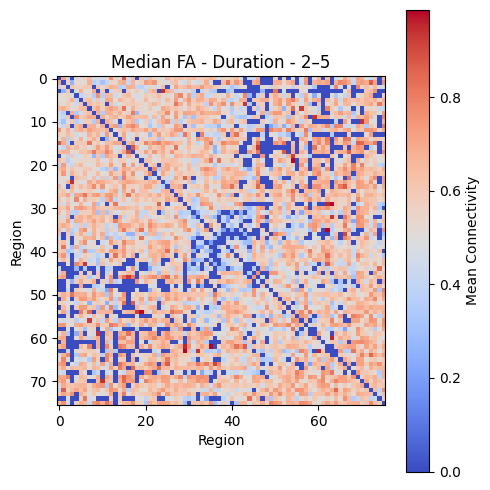

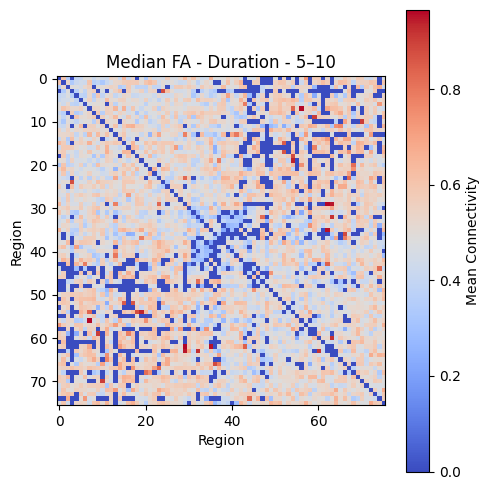

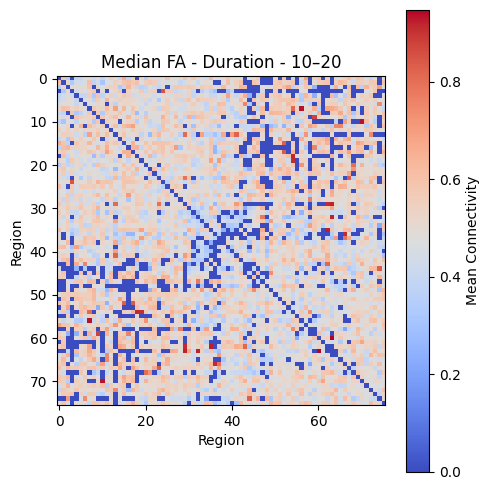

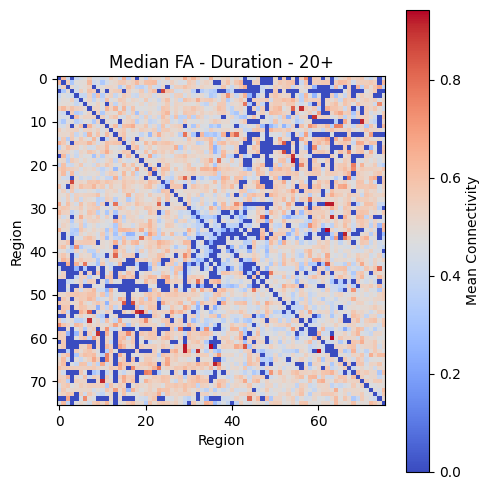

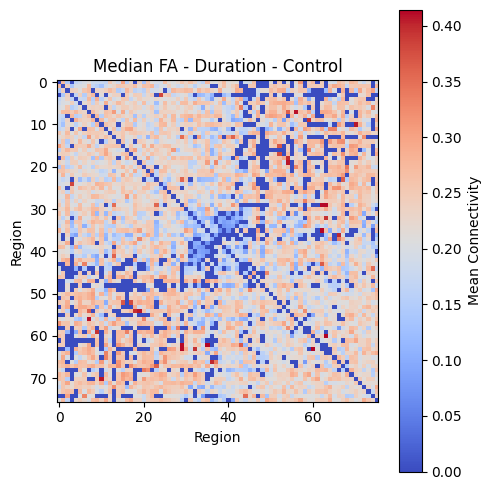

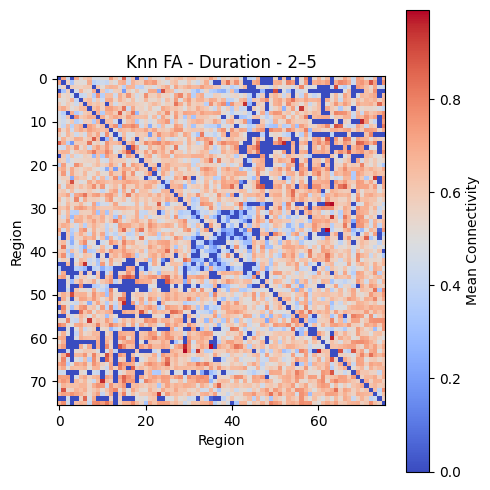

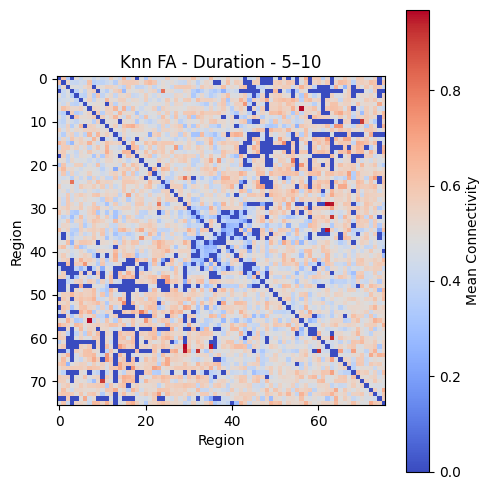

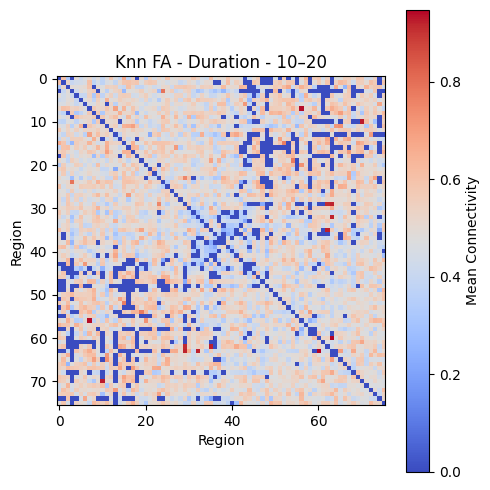

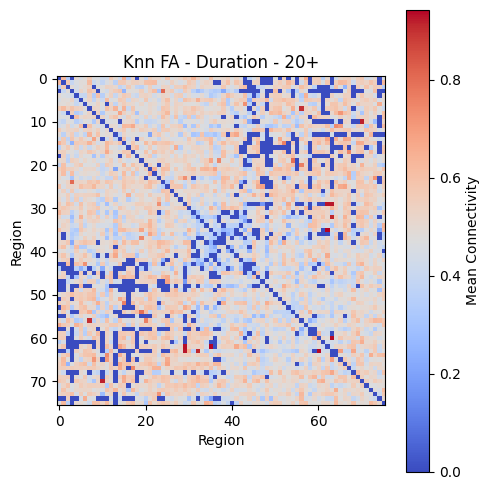

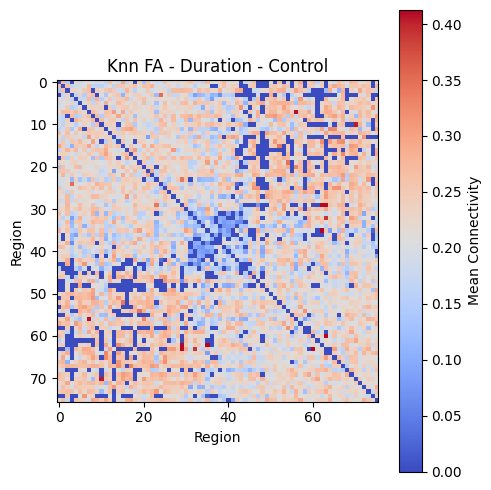

In [30]:
plot_group_mean_matrices(mean_matrices_dd_median, title_prefix="Median FA - Duration")
plot_group_mean_matrices(mean_matrices_dd_knn, title_prefix="Knn FA - Duration")

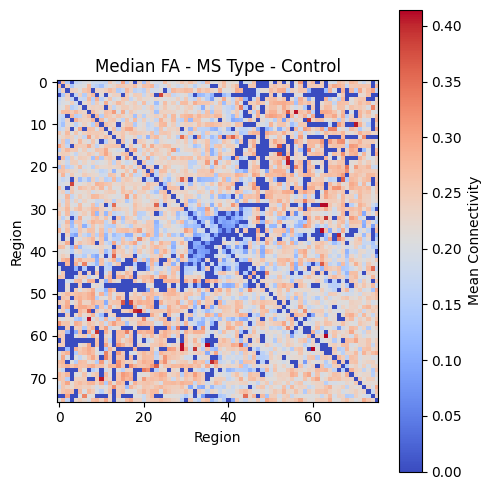

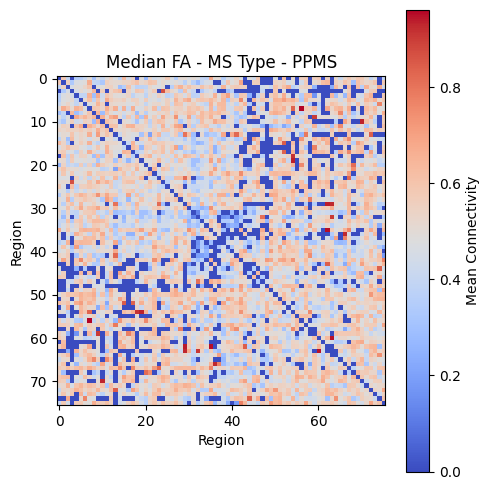

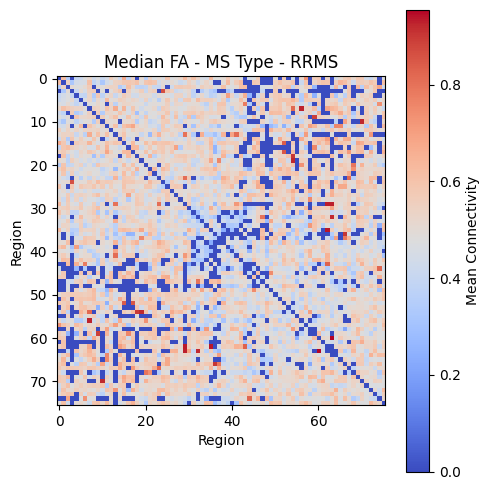

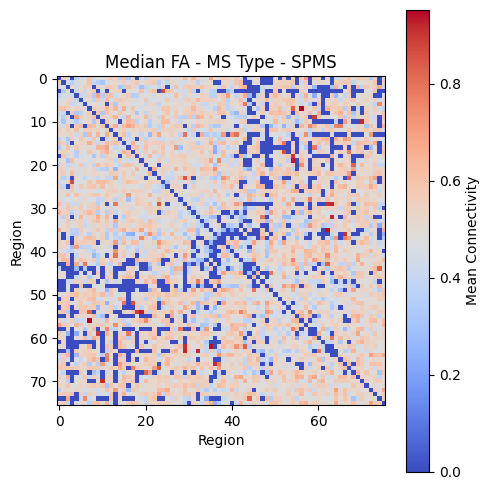

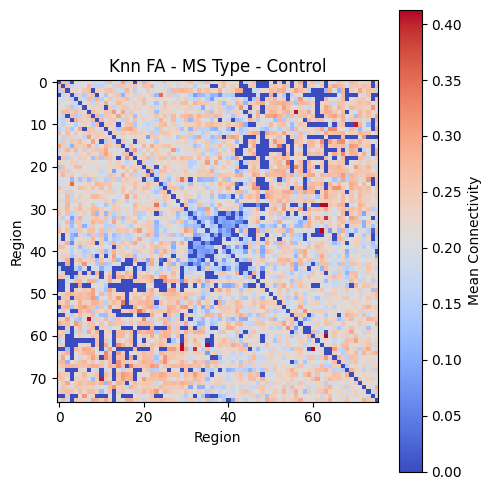

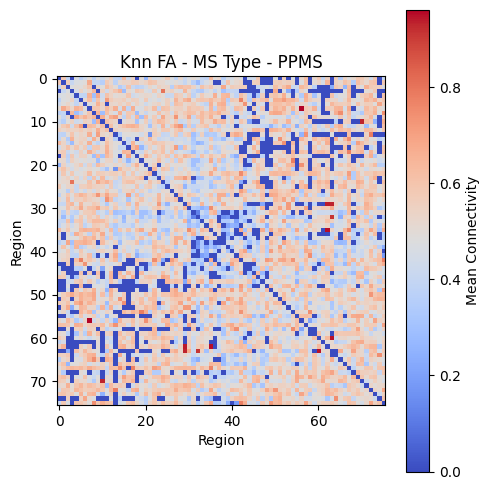

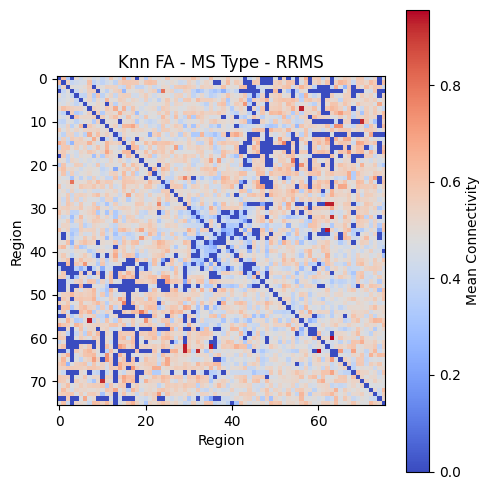

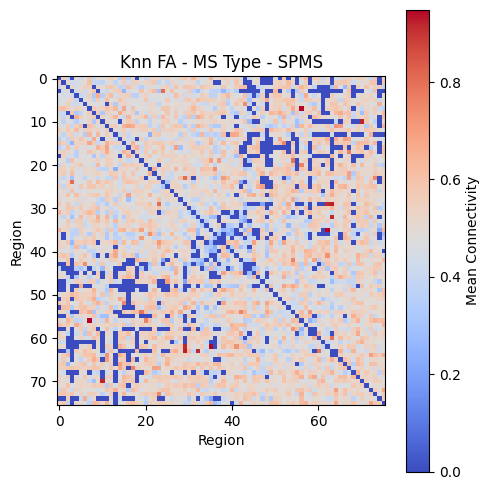

In [31]:
plot_group_mean_matrices(mean_matrices_mstype_median, title_prefix="Median FA - MS Type")
plot_group_mean_matrices(mean_matrices_mstype_knn, title_prefix="Knn FA - MS Type")

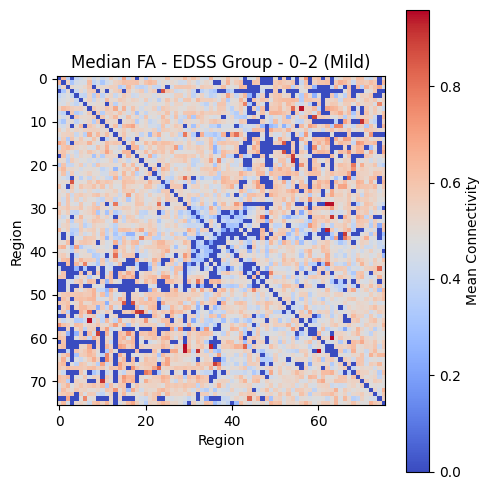

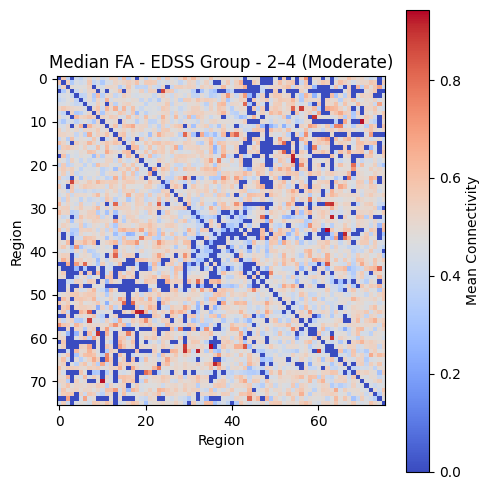

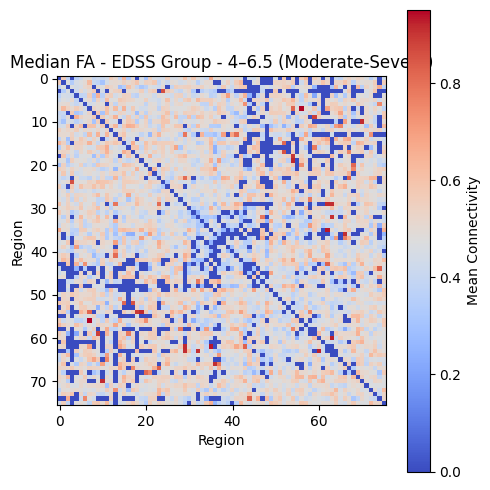

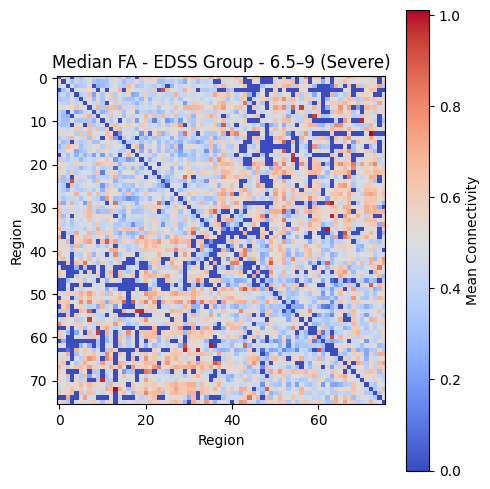

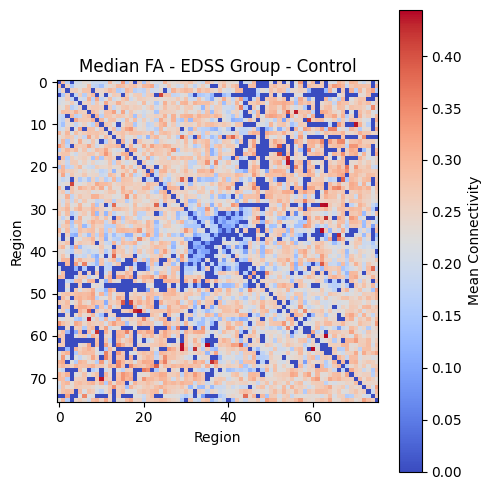

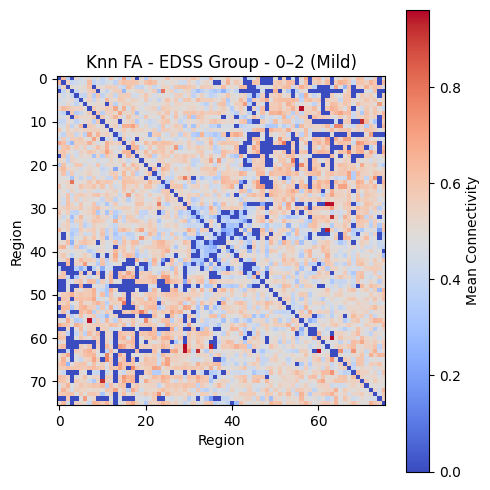

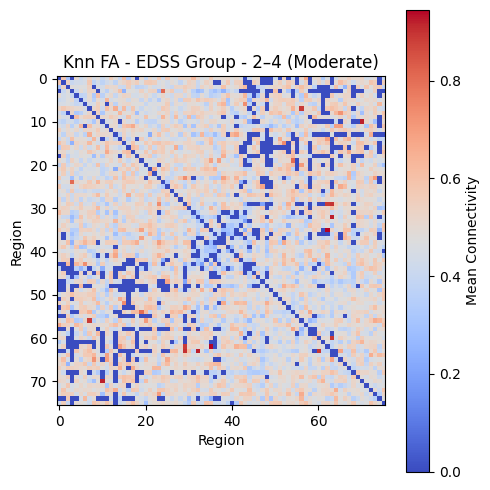

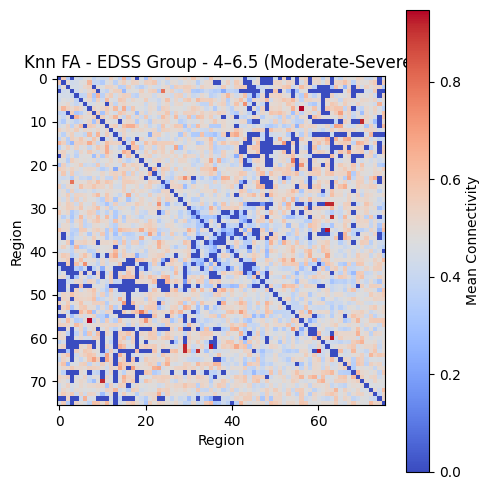

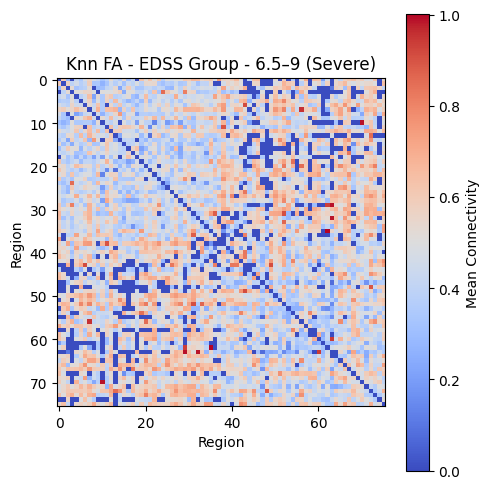

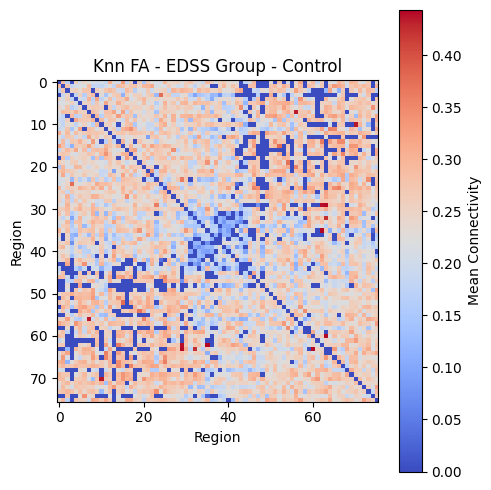

In [32]:
plot_group_mean_matrices(mean_matrices_edss_median, title_prefix="Median FA - EDSS Group")
plot_group_mean_matrices(mean_matrices_edss_knn, title_prefix="Knn FA - EDSS Group")

In [ ]:
# === 11. Save summary ===
# Group by dd_grp and collect subject IDs
ids_by_duration = patients.groupby('dd_grp').apply(lambda df: list(df.index))

# Convert to DataFrame (each row = one ID, with its group)
df_ids_by_duration = ids_by_duration.explode().reset_index()
df_ids_by_duration.columns = ['dd_group', 'subject_id']

# Save to CSV
df_ids_by_duration.to_csv(
    "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/ids_by_duration_ids.csv",
    index=False
)

print("✅ Subject IDs per duration group saved successfully.")

# Grouped summary statistics per disease duration group
group_summary = patients.groupby('dd_grp')[['age', 'sex', 'edss', 'dd']].describe()

# Export the full multi-level summary to CSV
group_summary.to_csv(
    "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/ids_by_duration_group_summary.csv"
)

print("✅ Group summary statistics saved successfully.")
